# Testing Action Recognition by video using XClip

In the Animal Kingdom dataset, action recognition is tested for unseen types of aniimals. Video clips of 6 action classes (moving, eating, attending, swimming, sensing, and keeping still). Then we select 4 animal types (birds, fishes, frogs, snakes) for training. Then we select 5 animal types for testing (lizards, primates, spiders, orthopteran insects, water fowls)

#### action indexes:
moving = 78 \
eating = 40 \
attending = 2 \
swimming = 123 \
sensing = 102 \
keeping still = 68

prepare data

In [143]:
# remove all videos that do not meet criteria
# 1. only 1 action
# 2. action is one of the following
# 3. species is listed

# so get all valid videos

import pandas as pd
import csv
import json
from tqdm import tqdm

In [144]:
# go through pose estimation data to find the frames of animals for training and testing dataset that correspond with the correct classes

# the training and val subclasses data structures are organized where the key of the dict is the official subclass name found the in the data, and the value is the alias we will use for the clip model

training_subclasses = {
    "Bird": "bird",
    "Fish": "fish",
    "Frog / Toad": "frog",
    "Snake / Cobra / Viper / Python": "snake"
}

# spiders and orthopteran insects not found in Animal Kingdom dataset
val_subclasses = {
    "Lizard / Gecko / Draco / Iguana / Chamelon": "lizard",
    "Primate / Monkey / Macaque / Baboon / Chimpanzee / Gorilla / Orangutan / Langur": "primate",
    "Water bird / Duck / Swan / Goose": "water fowl"
}

all_data = []
f = open("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/pose_estimation/annotation/ak_P1/train.json", "r")
train_set = json.load(f)
f.close()
all_data = all_data + train_set
f = open("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/pose_estimation/annotation/ak_P1/test.json", "r")
test_set = json.load(f)
f.close()
all_data = all_data + test_set

# example data element
# {
    # ak_P1/0000: {
    #     image_subclass: penguin,
    #     dataset: train,
    #     action: 3
    # }
# }
data = {}

# add all the animals that are listed in the training or testing dataset
for i in range(len(all_data)):
    animal = all_data[i]
    if animal["animal_subclass"] in training_subclasses:
        # have to replace _f with _t because the PE images have _f while AR frames have _t. even tho it's the same image
        frame = animal["image"].replace("_f", "_t")
        data[frame] = {
            "image_subclass": training_subclasses[animal["animal_subclass"]],
            "dataset": "train"
        }
    if animal["animal_subclass"] in val_subclasses:
        # have to replace _f with _t because the PE images have _f while AR frames have _t. even tho it's the same image
        frame = animal["image"].replace("_f", "_t")
        data[frame] = {
            "image_subclass": val_subclasses[animal["animal_subclass"]],
            "dataset": "validation"
        }

No accelerated colorspace conversion found from yuv420p to rgb24.
 (repeated 7 more times)


In [145]:
valid_actions = ["78", "40", "2", "123", "102", "68"]

# create list of images from the training and testing set
csv_path = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/train.csv"
frame_train = pd.read_csv(csv_path, delimiter=' ', skiprows=[0])
csv_path = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/val.csv"
frame_val = pd.read_csv(csv_path, delimiter=' ', skiprows=[0])

combined_frame = pd.concat([frame_train, frame_val])

for row in combined_frame.itertuples(index=False):
    path = row[3]
    if path in data:
        action_indexes = row[4].split(",")
        # as per the paper, only include frames with 1 action
        if len(action_indexes) == 1:
            if action_indexes[0] in valid_actions:
                data[path]["action"] = action_indexes[0]

# delete all the frames that don't have an action
for key in list(data.keys()):
    if "action" not in data[key]:
        del data[key]

In [146]:
video_data = {}
for key in data:
    if key[:key.index("/")] not in video_data:
        video_data[key[:key.index("/")]] = data[key]

## Testing
`1` is True. `0` is False.

In [147]:
# utility functions

import av
import torch
import numpy as np
from time import sleep
from transformers import AutoProcessor, AutoModel
from huggingface_hub import hf_hub_download

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


# seg_len is the total number of frames in the video
# clip_len is the number of frames we want to sample from the video
# frame_sample_rate is the number of frames we want to sample per second
def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

processor = AutoProcessor.from_pretrained("microsoft/xclip-base-patch32")
model = AutoModel.from_pretrained("microsoft/xclip-base-patch32")

import sys
from contextlib import redirect_stdout, redirect_stderr

test for "a `{animal}` is `{action}`". example: "a dog is swimming"

In [148]:
# create the strings using the above "a {animal} is {action}" format to be fed into CLIP

df = pd.read_excel("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/df_action.xlsx")

training_strings = []
val_strings = []

for subclass in training_subclasses:
    for action in valid_actions:
        training_strings.append(f"a {training_subclasses[subclass]} is {df.at[int(action), 'action'].lower()}")

for subclass in val_subclasses:
    for action in valid_actions:
        val_strings.append(f"a {val_subclasses[subclass]} is {df.at[int(action), 'action'].lower()}")

In [152]:
database_train_subclass = {
    "bird": [],
    "fish": [],
    "frog": [],
    "snake": []
}
database_val_subclass = {
    "lizard": [],
    "primate": [],
    "water fowl": []
}

database_actions_subclass = {}

video_dir = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/dataset/video/"

# get 8 frames spread throughout the video
def get_frames(clip_len):
    return np.linspace(0, clip_len - 1, 8).astype(np.int64)

for vid_path, _ in tqdm(video_data.items()):
    with redirect_stdout(None), redirect_stderr(None):
        label_num = video_data[vid_path]["action"]
        full_image_path = video_dir + vid_path
        
        correct_label = df.at[int(label_num), 'action'].lower()


        # read in video
        container = av.open(video_dir + vid_path + ".mp4")

        # sample 8 frames
        indices = sample_frame_indices(clip_len=8, frame_sample_rate = container.streams.video[0].frames // 8 - 1, seg_len=container.streams.video[0].frames)
        video = read_video_pyav(container, get_frames(clip_len=8))

        text_labels = training_strings if video_data[vid_path]["dataset"] == "train" else val_strings

        inputs = processor(
            text=text_labels,
            videos=list(video),
            return_tensors="pt",
            padding=True,
        )

        # forward pass
        with torch.no_grad():
            outputs = model(**inputs)

        logits_per_video = outputs.logits_per_video  # this is the video-text similarity score
        probs = logits_per_video.softmax(dim=1)  # we can take the softmax to get the label probabilities
        index = torch.argmax(probs)


        # add stat for subclass accuracy stat
        if video_data[vid_path]["dataset"] == "train":
            action = training_strings[index].split(" ")[-1]
            if action == correct_label:
                database_train_subclass[video_data[vid_path]["image_subclass"]].append(1)
            else:
                database_train_subclass[video_data[vid_path]["image_subclass"]].append(0)
        else:
            action = val_strings[index].split(" ")[-1]
            if action == correct_label:
                database_val_subclass[video_data[vid_path]["image_subclass"]].append(1)
            else:
                database_val_subclass[video_data[vid_path]["image_subclass"]].append(0)
        
        # add stat for action accuracy stat
        if correct_label not in database_actions_subclass:
            database_actions_subclass[correct_label] = []
        if action == correct_label:
            database_actions_subclass[correct_label].append(1)
        else:
            database_actions_subclass[correct_label].append(0)

100%|██████████| 1436/1436 [08:12<00:00,  2.92it/s]


In [154]:
database_train_subclass_avg = []
for animal in database_train_subclass:
    database_train_subclass_avg += database_train_subclass[animal]
    database_train_subclass[animal] = database_train_subclass[animal].count(1) / len(database_train_subclass[animal])

database_val_subclass_avg = []
for animal in database_val_subclass:
    database_val_subclass_avg += database_val_subclass[animal]
    database_val_subclass[animal] = database_val_subclass[animal].count(1) / len(database_val_subclass[animal])

print(database_train_subclass_avg)
print(database_val_subclass_avg)
print(database_train_subclass)
print(database_val_subclass)

No accelerated colorspace conversion found from yuv420p to rgb24.
 (repeated 7 more times)


TypeError: 'float' object is not iterable

In [ ]:
import av
import torch
import numpy as np

from transformers import AutoProcessor, AutoModel
from huggingface_hub import hf_hub_download

np.random.seed(0)


def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices


# video clip consists of 300 frames (10 seconds at 30 FPS)
container = av.open("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/dataset/video/AAACXZTV.mp4")

# sample 8 frames
indices = sample_frame_indices(clip_len=8, frame_sample_rate= container.streams.video[0].frames // 8 - 1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

processor = AutoProcessor.from_pretrained("microsoft/xclip-base-patch32")
model = AutoModel.from_pretrained("microsoft/xclip-base-patch32")

inputs = processor(
    text=["ostrich standing", "bug standing", "cow standing"],
    videos=list(video),
    return_tensors="pt",
    padding=True,
)

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

logits_per_video = outputs.logits_per_video  # this is the video-text similarity score
probs = logits_per_video.softmax(dim=1)  # we can take the softmax to get the label probabilities
print(probs)


No accelerated colorspace conversion found from yuv420p to rgb24.
 (repeated 7 more times)
No accelerated colorspace conversion found from yuv420p to rgb24.


tensor([[0.6951, 0.2023, 0.1026]])


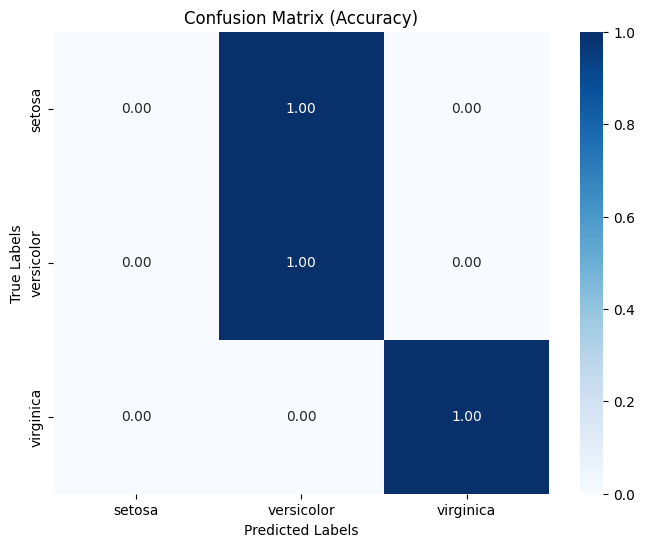

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Load example data (Iris dataset)
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (e.g., Support Vector Machine)
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy for each class and normalize the confusion matrix
class_accuracy = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix as a heatmap with accuracy percentages
plt.figure(figsize=(8, 6))
sns.heatmap(class_accuracy, annot=True, cmap='Blues', fmt='.2f', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Accuracy)')
plt.show()
